## Let's understand the data behind the meme through analysis of the cards
https://preview.redd.it/me-whos-trying-to-get-back-to-the-game-v0-02xzy4rnqycb1.jpg?width=640&crop=smart&auto=webp&s=c93b16f6372b8bb023d8c866757cb91192983629

Most players or previous player of the game can tell you that it's not what it used to be "back in the day". 

We can find how the official rules have changed [online](http://https://yugioh.fandom.com/wiki/TCG_Rule_Changes) for example in 2008.

But what we are insterrested here is how the cards themselves and their current playability have impacted the game.

For example through their special effects in Chains.

In [1]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import fuzzywuzzy
from fuzzywuzzy import process
import charset_normalizer
import scipy.stats as stats


print("Setup Complete")

Setup Complete


/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
#Loading the data
cards_filepath = "/kaggle/input/yugioh-cards/cards.csv"
cards_data = pd.read_csv(cards_filepath)

pd.set_option('display.max_colwidth', None)

In [4]:
# Replace inf and -inf with NaN explicitly
cards_data = cards_data.replace([np.inf, -np.inf], np.nan)

In [5]:
#Looking for empty cells in each column
missing_values_count = cards_data.isnull().sum()
missing_values_count[0:29]

id                     0
name                   0
type                   0
desc                   0
atk                 4650
def                 5065
level               5065
race                   1
attribute           4650
scale              12933
archetype           5493
linkval            12866
linkmarkers        12866
image_url              0
image_url_small        0
ban_tcg            13086
ban_ocg            13091
ban_goat           13208
staple             13217
views                  0
viewsweek              0
upvotes                0
downvotes              0
formats               13
treated_as         13139
tcg_date             416
ocg_date             400
konami_id            480
has_effect             0
dtype: int64

There are a lot of missing values regarding the characteristics of cards like atk, def, etc. but this is explained contextually because they only apply to the monster cards types.


In [6]:
#Looking for duplicates in cards names
total_values_cards = cards_data['name'].value_counts().sum()
total_unique_values_cards = cards_data['name'].nunique()

print("The number of entries in the name column is :",total_values_cards, ", and the number of unique entries in the name column is :",total_unique_values_cards)

The number of entries in the name column is : 13281 , and the number of unique entries in the name column is : 13281


There are no duplicates in the names of the cards so we can continue on with our analysis.

Here we can see their repartition of the type of cards in the data set :

Text(0, 0.5, 'Type')

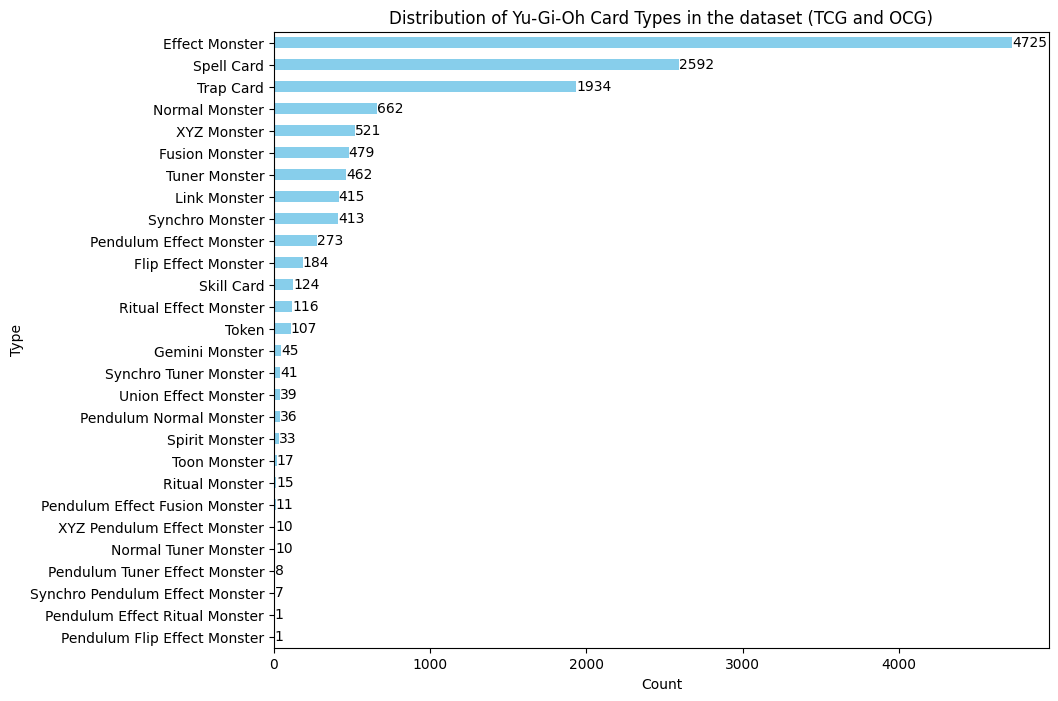

In [7]:
# Get the value counts for the 'type' column
type_counts = cards_data['type'].value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 8))
type_counts.sort_values().plot(kind='barh', color='skyblue')
# Add counts to the bars
for index, value in enumerate(type_counts.sort_values()):
    plt.text(value, index, str(value), va='center')  # `value` is the count, `index` is the bar position
plt.title('Distribution of Yu-Gi-Oh Card Types in the dataset (TCG and OCG)')
plt.xlabel('Count')
plt.ylabel('Type')

The Yu-Gi-Oh game and cards are separated into 2 categories depending on your location : TCG (Trading Card Game) and OCG (Original Card Game).
> OCG is played in asia (Japan, Korea, China and so on) while the TCG is played everywhere else (America, Europe and so on). (source: https://yugipedia.com/wiki/Forum:What_is_OCG_and_TCG%3F_whats_the_difference%3F)

In competitive spheres the rules and availability of the cards are different depending on TCG and OCG. This include cards that have become banned. 

In [8]:
cards_data['tcg_date'].dtype
print(cards_data['tcg_date'].head())

0    2007-05-16
1    2007-11-14
2    2016-11-03
3    2007-02-28
4    2023-07-27
Name: tcg_date, dtype: object


In [9]:
#Convert to the date format because the type of the column 'tcg_date' is object
cards_data['tcg_date_parsed']= pd.to_datetime(cards_data['tcg_date'], format= "%Y-%m-%d", errors="coerce")
#Convert to the date format because the type of the column 'ocg_date' is object
cards_data['ocg_date_parsed']= pd.to_datetime(cards_data['ocg_date'], format= "%Y-%m-%d",errors="coerce")

#Time categories
#year
cards_data["tcg_year"] = cards_data["tcg_date_parsed"].dt.year
cards_data["ocg_year"] = cards_data["ocg_date_parsed"].dt.year

cards_data = cards_data.dropna(subset=["tcg_year", "ocg_year"])
cards_data["tcg_year"] = cards_data["tcg_year"].astype(int)
cards_data["ocg_year"] = cards_data["ocg_year"].astype(int)

#year months for later use
cards_data["tcg_year_month"] = cards_data["tcg_date_parsed"].dt.to_period("M")
cards_data["ocg_year_month"] = cards_data["ocg_date_parsed"].dt.to_period("M")

cards_data["tcg_year_month"] = cards_data["tcg_year_month"].dt.to_timestamp()
cards_data["ocg_year_month"] = cards_data["ocg_year_month"].dt.to_timestamp()



In [10]:
cards_data["tcg_year_month"].head()
#so it puts every entry at the first of the month, I see

0   2007-05-01
1   2007-11-01
2   2016-11-01
3   2007-02-01
4   2023-07-01
Name: tcg_year_month, dtype: datetime64[ns]

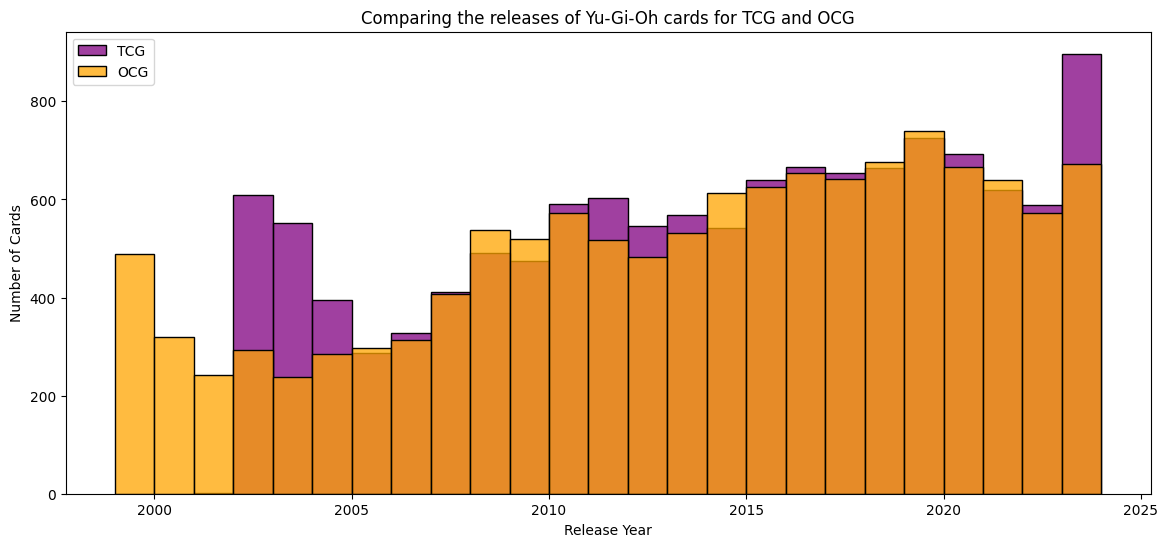

In [11]:
#Let's analyse the number of cards releases

plt.figure(figsize=(14,6))
plt.title("Comparing the releases of Yu-Gi-Oh cards for TCG and OCG")
sns.histplot(cards_data["tcg_year"], color="purple", label="TCG", bins=range(cards_data["tcg_year"].min(), cards_data["tcg_year"].max() + 1) )
sns.histplot(cards_data["ocg_year"], color= "orange", label= "OCG", bins=range(cards_data["ocg_year"].min(), cards_data["ocg_year"].max() + 1))
plt.xlabel("Release Year")
plt.ylabel("Number of Cards")
plt.legend()
plt.show()

In [12]:
print("The earliest year a card was released on for the Original Card Game (OCG) was", int(cards_data["ocg_year"].min()),
      ", and the earliest year for the more international Trading Card Game (TCG) was",int(cards_data["tcg_year"].min()) ,"." )

The earliest year a card was released on for the Original Card Game (OCG) was 1999 , and the earliest year for the more international Trading Card Game (TCG) was 2001 .


> https://www.reddit.com/r/yugioh/comments/o6qbuy/the_wacky_timeline_of_early_yugioh_and_where/ 

In [13]:
tcg_2001=0
tcg_2002=0

for i in cards_data["tcg_year"]:
    if i ==2001:
        tcg_2001 +=1

for i in cards_data["tcg_year"]:
    if i ==2002:
        tcg_2002 +=1
        
print("The number of cards released during the first year of TCG was :", tcg_2001, "; and the second year :", tcg_2002, ".")
print("The first card released in 2001 for TCG was :" , cards_data.loc[cards_data["tcg_year"] == 2001, "name"].iloc[0])

print(cards_data.loc[cards_data["tcg_year"] == 2001, "formats"])

The number of cards released during the first year of TCG was : 1 ; and the second year : 609 .
The first card released in 2001 for TCG was : Summoned Skull
11002    GOAT|OCG GOAT|Duel Links|Common Charity|Speed Duel|TCG|OCG|Master Duel
Name: formats, dtype: object


Why has only the card Summonned Skull been released in 2001 ?

After some research, I have found that it was first released as a sample promotional cards in 2001 for retailers in North America. https://yugipedia.com/wiki/Summoned_Skull https://yugipedia.com/wiki/Summoned_Skull_Sample_promotional_card

As we can see in the rest of the dataset, the launch of Yu-Gi-Oh for the TCG market really started in 2002.

I will consider that the promotional cards as regular cards since according to https://yugioh.fandom.com/wiki/Category:TCG_promotional_cards , there are only 84 items regarding the "promotional" term in search; and the sample cards are published later anyways.

In [14]:
#Fixing the Summoned Skull issue with its promotionnal release date and affecting to the official release date
#because it is impacting later calculations
cards_data.loc[cards_data["tcg_year"] == 2001, "tcg_year"] = 2002

# Are there more cards in TCG or OCG ?

In [15]:
#Total of cards
total_cards_tcg = cards_data['tcg_date_parsed'].value_counts().sum()
total_cards_ocg = cards_data['ocg_date_parsed'].value_counts().sum()

print("The total number of cards for TCG is",total_cards_tcg," and for OCG is",total_cards_ocg)

#Number of cards in the ban list
total_ban_tcg = cards_data['ban_tcg'].value_counts().sum()
total_ban_ocg = cards_data['ban_ocg'].value_counts().sum()

print('The ban list including "Banned","Limited" and "Semi-Limited" statuses for TCG is',total_ban_tcg,"and for OCG is ",total_ban_ocg)

#Number of cards completely banned
total_banned_tcg = cards_data[cards_data['ban_tcg'] == "Banned"].shape[0]
total_banned_ocg = cards_data[cards_data['ban_ocg'] == "Banned"].shape[0]

#Usable cards in TCG vs OCG
usable_cards_tcg = total_cards_tcg - total_ban_tcg
usable_cards_ocg = total_cards_ocg - total_ban_ocg

print("The number of usable cards to this day for TCG is",usable_cards_tcg,"and for OCG is",usable_cards_ocg)

percent_of_bans_tcg = round(total_ban_tcg/total_cards_tcg*100, 2)
percent_of_bans_ocg = round(total_ban_ocg/total_cards_ocg*100, 2)
percent_banned_tcg = round(total_banned_tcg/total_cards_tcg*100, 2)
percent_banned_ocg = round(total_banned_ocg/total_cards_ocg*100, 2)

print("The ban list represent", percent_of_bans_tcg ,"% of the TCG pool.")
print("The ban list cards represent", percent_of_bans_ocg,"% of the OCG pool.")

print("And the number of cards completely banned is even lower. It equals to", percent_banned_tcg ,"% of the TCG pool and ",percent_banned_ocg, "% for the OCG pool of cards." )

The total number of cards for TCG is 12542  and for OCG is 12542
The ban list including "Banned","Limited" and "Semi-Limited" statuses for TCG is 195 and for OCG is  190
The number of usable cards to this day for TCG is 12347 and for OCG is 12352
The ban list represent 1.55 % of the TCG pool.
The ban list cards represent 1.51 % of the OCG pool.
And the number of cards completely banned is even lower. It equals to 0.84 % of the TCG pool and  0.69 % for the OCG pool of cards.


To keep examining the differences between TCG and OCG, let's examine their ban lists to see if they coincide.

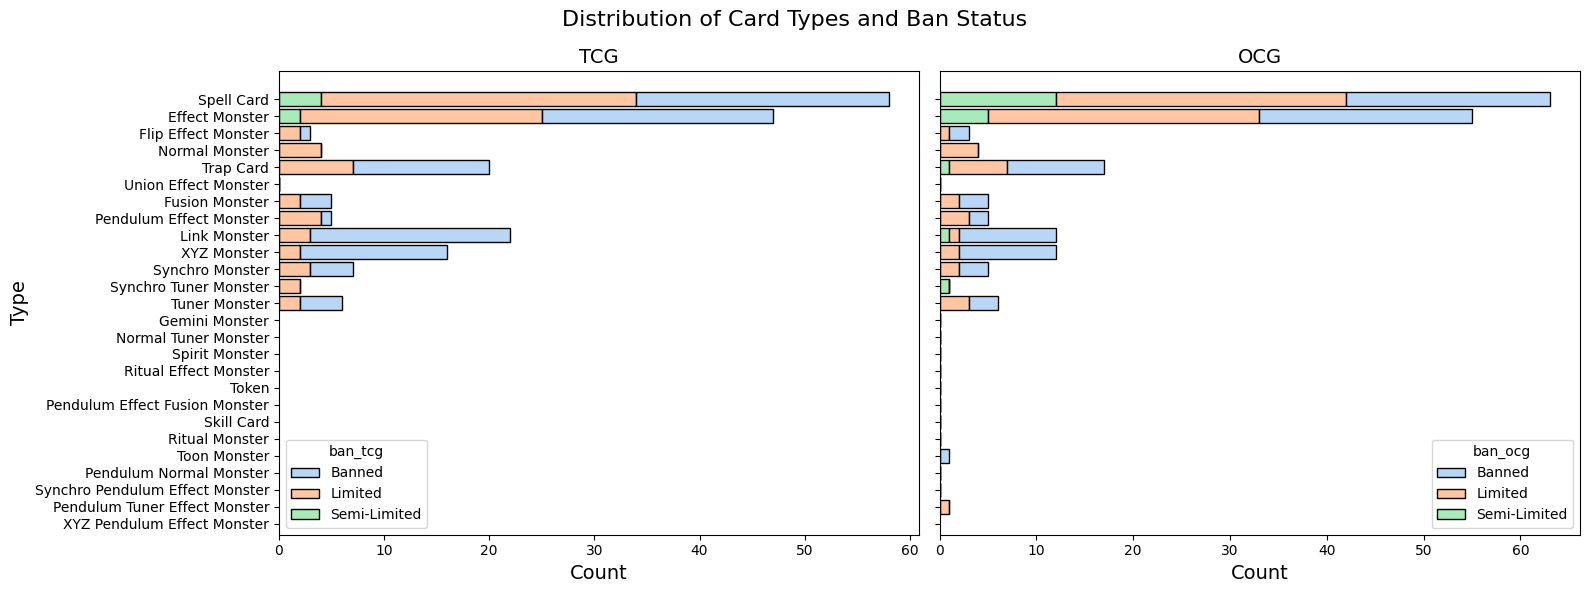

In [16]:
# Ensure 'ban_tcg' and 'ban_ocg' columns are categorical to avoid warnings
cards_data["ban_tcg"] = cards_data["ban_tcg"].astype("category")
cards_data["ban_ocg"] = cards_data["ban_ocg"].astype("category")


fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
fig.suptitle('Distribution of Card Types and Ban Status', ha = "center", fontsize=16)

ax = sns.histplot( data=cards_data, y='type', hue='ban_tcg', multiple='stack', shrink=0.8, palette='pastel',ax=axes[0] ) # Specify which subplot to draw on

#for container in ax.containers:
#    ax.bar_label(container, fmt='%d', fontsize=8)

ax.set_title("TCG", fontsize=14)
ax.set_xlabel("Count", fontsize=14)
ax.set_ylabel("Type", fontsize=14)

ax_a = sns.histplot( data=cards_data, y='type', hue='ban_ocg', multiple='stack', shrink=0.8, palette='pastel', ax=axes[1])  # Specify which subplot to draw on 

#for container in ax_a.containers:
#    ax_a.bar_label(container, fmt='%d', fontsize=8)

ax_a.set_title("OCG", fontsize=14)
ax_a.set_xlabel("Count", fontsize=14)
ax_a.set_ylabel("")  # Remove redundant y-axis label

plt.tight_layout()

plt.show()

<ipython-input-17-bfb5324a7e86>:12: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  ax_1 = sns.histplot(data=banned_tcg_data, y='type', hue='ban_tcg', multiple='stack', shrink=0.8, palette = ['purple'],ax=axes[0], legend=False ) # Specify which subplot to draw on
<ipython-input-17-bfb5324a7e86>:21: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  ax_2 = sns.histplot(data=banned_ocg_data, y='type', hue='ban_ocg', multiple='stack', shrink=0.8, palette = ['orange'] , ax=axes[1],legend=False)  # Specify which subplot to draw on


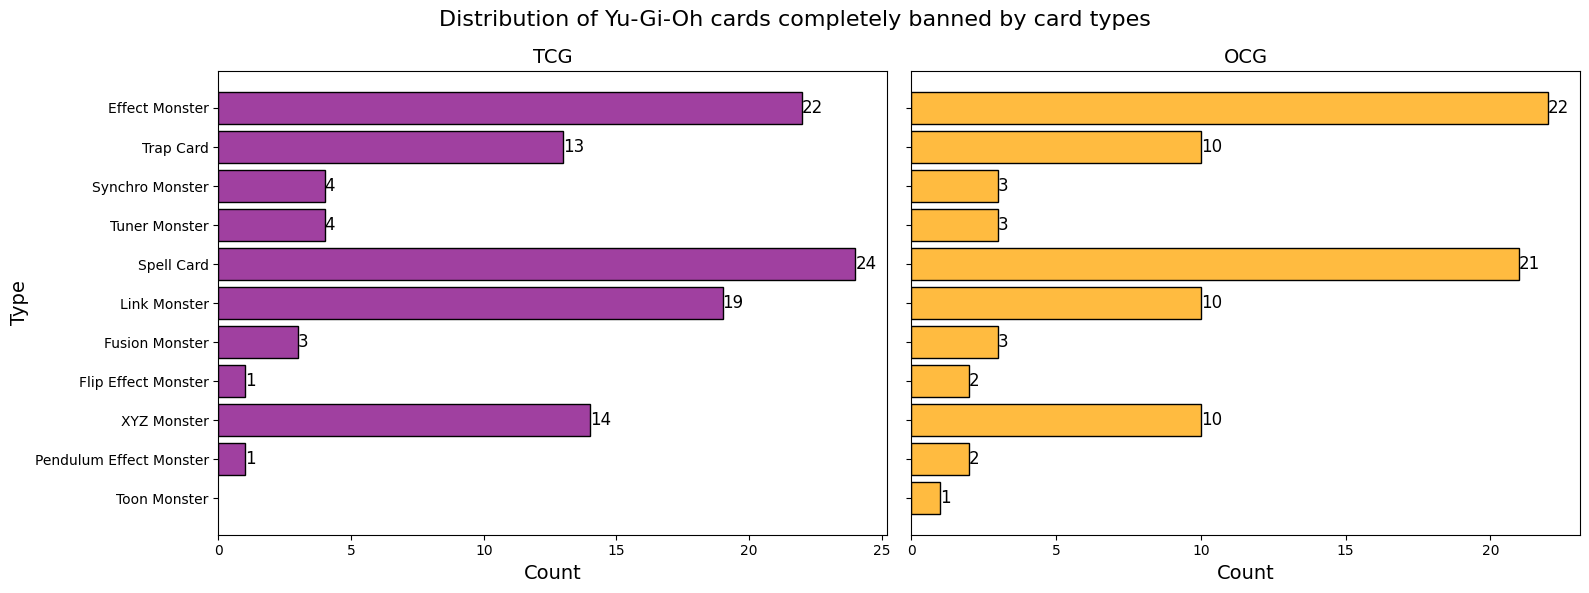

In [17]:
# Ensure 'ban_tcg' and 'ban_ocg' columns are categorical to avoid warnings
cards_data["ban_tcg"] = cards_data["ban_tcg"].astype("category")
cards_data["ban_ocg"] = cards_data["ban_ocg"].astype("category")

banned_tcg_data = cards_data[cards_data["ban_tcg"] == "Banned"]
banned_ocg_data = cards_data[cards_data["ban_ocg"] == "Banned"]


fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
fig.suptitle('Distribution of Yu-Gi-Oh cards completely banned by card types', ha = "center", fontsize=16)

ax_1 = sns.histplot(data=banned_tcg_data, y='type', hue='ban_tcg', multiple='stack', shrink=0.8, palette = ['purple'],ax=axes[0], legend=False ) # Specify which subplot to draw on

for container in ax_1.containers:
    ax_1.bar_label(container, fmt='%d', fontsize=12)

ax_1.set_title("TCG", fontsize=14)
ax_1.set_xlabel("Count", fontsize=14)
ax_1.set_ylabel("Type", fontsize=14)

ax_2 = sns.histplot(data=banned_ocg_data, y='type', hue='ban_ocg', multiple='stack', shrink=0.8, palette = ['orange'] , ax=axes[1],legend=False)  # Specify which subplot to draw on 

for container in ax_2.containers:
    ax_2.bar_label(container, fmt='%d', fontsize=12)

ax_2.set_title("OCG", fontsize=14)
ax_2.set_xlabel("Count", fontsize=14)
ax_2.set_ylabel("")  # Remove redundant y-axis label

plt.tight_layout()

plt.show()

METTRE UNE LEGENDE EN BAS

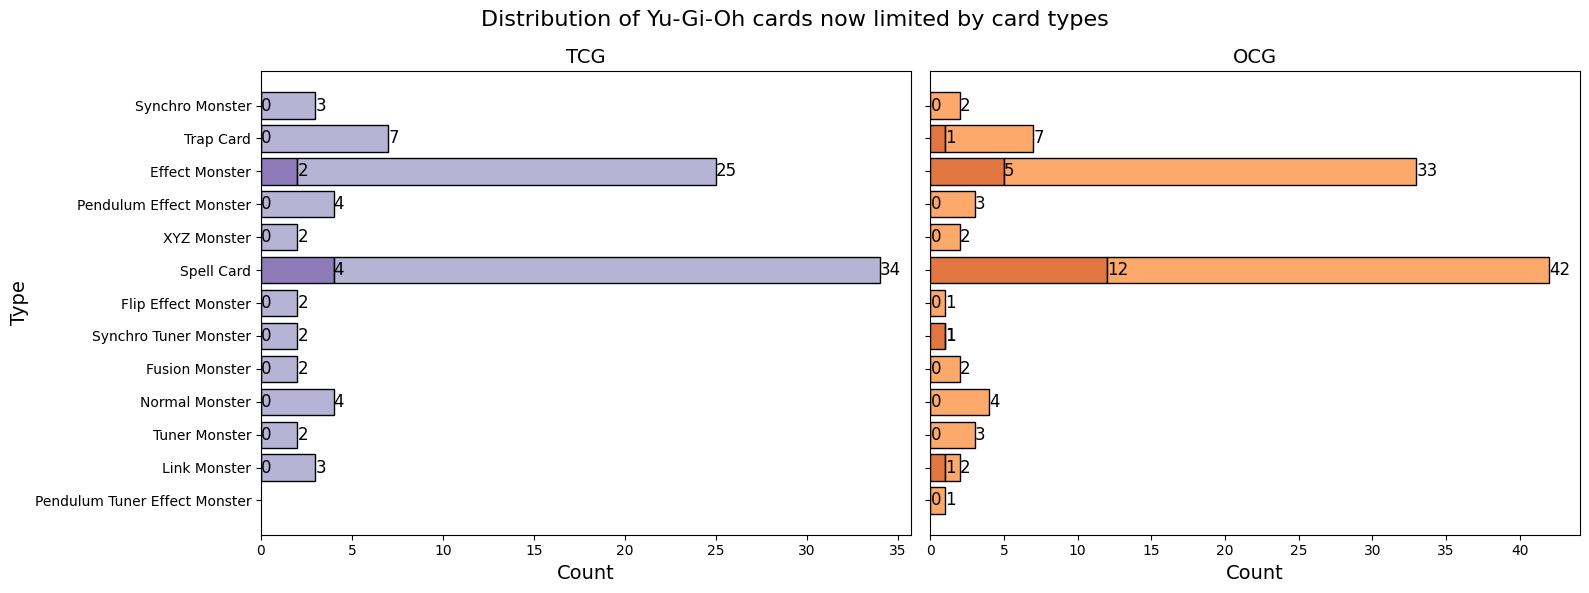

In [18]:
limited_tcg_data = cards_data[cards_data["ban_tcg"].isin(["Limited", "Semi-Limited"])]
limited_ocg_data = cards_data[cards_data["ban_ocg"].isin(["Limited", "Semi-Limited"])]


fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
fig.suptitle('Distribution of Yu-Gi-Oh cards now limited by card types', ha = "center", fontsize=16)

ax_1 = sns.histplot(data=limited_tcg_data, y='type', hue='ban_tcg', multiple='stack', shrink=0.8, palette = 'Purples',ax=axes[0], legend=False ) # Specify which subplot to draw on

for container in ax_1.containers:
    ax_1.bar_label(container, fmt='%d', fontsize=12)

ax_1.set_title("TCG", fontsize=14)
ax_1.set_xlabel("Count", fontsize=14)
ax_1.set_ylabel("Type", fontsize=14)

ax_2 = sns.histplot(data=limited_ocg_data, y='type', hue='ban_ocg', multiple='stack', shrink=0.8, palette = 'Oranges' , ax=axes[1],legend=False)  # Specify which subplot to draw on 

for container in ax_2.containers:
    ax_2.bar_label(container, fmt='%d', fontsize=12)

ax_2.set_title("OCG", fontsize=14)
ax_2.set_xlabel("Count", fontsize=14)
ax_2.set_ylabel("")  # Remove redundant y-axis label

plt.tight_layout()

plt.show()

So we can see here some differences in the distribution of cards available in TCG and OCG even if each pool of cards is similar. 
Although these differences are very specific to the ban list which only represent 1.5% in both TCG (195 cards) and OCG (190 cards) pools. 

# Trends in Monsters Cards 

In [19]:
#creating a new type column where we regroup all types of monsters (tokens are left seperate even if they are considered as monsters too)
cards_data["primary_type"]= cards_data.loc[:,"type"]

#renaming all the monster adjacent cards to monster primary type
cards_data.loc[cards_data["primary_type"].str.contains(r'\bMonster\b', regex=True) ,'primary_type'] = 'Monster Card'

# ensure "primary_type" columns is categorical
cards_data["primary_type"] = cards_data["primary_type"].astype("category")

#to check
cards_data["primary_type"].value_counts()

#to use more easily and only select the monster type of cards
monster_cards_data = cards_data[cards_data["primary_type"]=="Monster Card"]


In [20]:
def m_card_quantitative_values_plot (operation,data_tcg, data_ocg, parameter_col=None, time_col_tcg=None, time_col_ocg=None, ax=None ):
    # Create a single plot with multiple subplots (one for each line plot)
    #If no ax is provided, create a new figure
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot the TCG data
    sns.lineplot(data=data_tcg, x=time_col_tcg, y=parameter_col, ax=ax, label="TCG", color='purple')
    
    # Plot the OCG data
    sns.lineplot(data=data_ocg, x=time_col_ocg, y=parameter_col, ax=ax, label="OCG", color='orange')
    
    # Customize plot
    ax.set_title(f"{operation} {parameter_col} over time")
    ax.set_xlabel("Release year")
    ax.set_ylabel(f"{operation} {parameter_col}")

    if ax is None:
        plt.show()

### Attack points  

In [21]:
# Group by the year and month and calculate the mean et median attack 
avg_atk_tcg = cards_data[cards_data["primary_type"]=="Monster Card"].groupby("tcg_year")["atk"].mean().reset_index()
avg_atk_ocg = cards_data[cards_data["primary_type"]=="Monster Card"].groupby("ocg_year")["atk"].mean().reset_index()

median_atk_tcg = cards_data[cards_data["primary_type"]=="Monster Card"].groupby("tcg_year")["atk"].median().reset_index()
median_atk_ocg = cards_data[cards_data["primary_type"]=="Monster Card"].groupby("ocg_year")["atk"].median().reset_index()

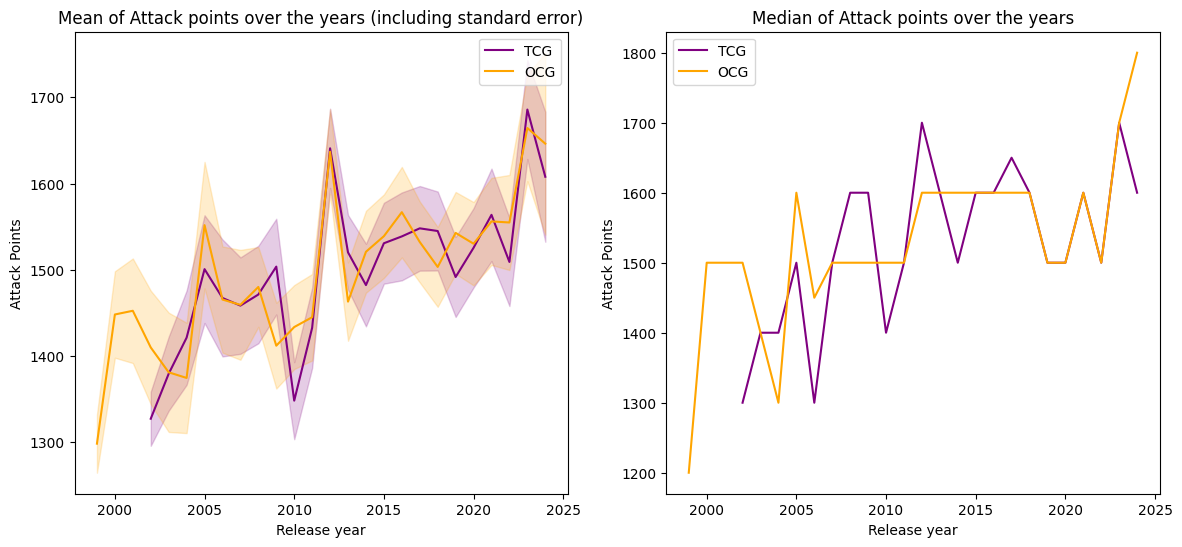

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))


sns.lineplot(data=monster_cards_data, x="tcg_year", y="atk", label="TCG", color='purple', ax=axes[0], errorbar="se")
sns.lineplot(data=monster_cards_data, x="ocg_year", y="atk", label="OCG", color='orange', ax=axes[0], errorbar="se")
axes[0].set_title("Mean of Attack points over the years (including standard error)")
axes[0].set_xlabel("Release year")
axes[0].set_ylabel("Attack Points")

sns.lineplot(data=monster_cards_data, x="tcg_year", y="atk", label="TCG", color='purple', ax=axes[1], estimator=np.median, errorbar=None)
sns.lineplot(data=monster_cards_data, x="ocg_year", y="atk", label="OCG", color='orange', ax=axes[1], estimator=np.median, errorbar=None)
axes[1].set_title("Median of Attack points over the years")
axes[1].set_xlabel("Release year")
axes[1].set_ylabel("Attack Points")

plt.show()

((array([-3.75897106, -3.53090833, -3.40556289, ...,  3.40556289,
          3.53090833,  3.75897106]),
  array([   0.,    0.,    0., ..., 5000., 5000., 5000.])),
 (936.8477849772221, 1500.294153846154, 0.9858879936485474))

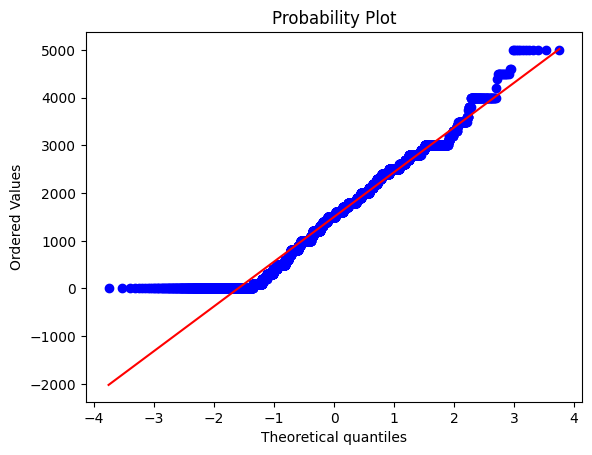

In [23]:
stats.probplot(monster_cards_data["atk"], dist="norm", plot=plt)


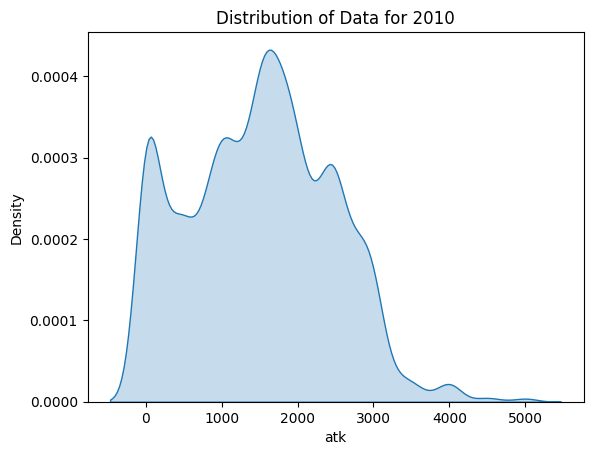

In [24]:
sns.kdeplot(data=monster_cards_data["atk"], shade=True)
plt.title("Distribution of Data for 2010")
plt.show()

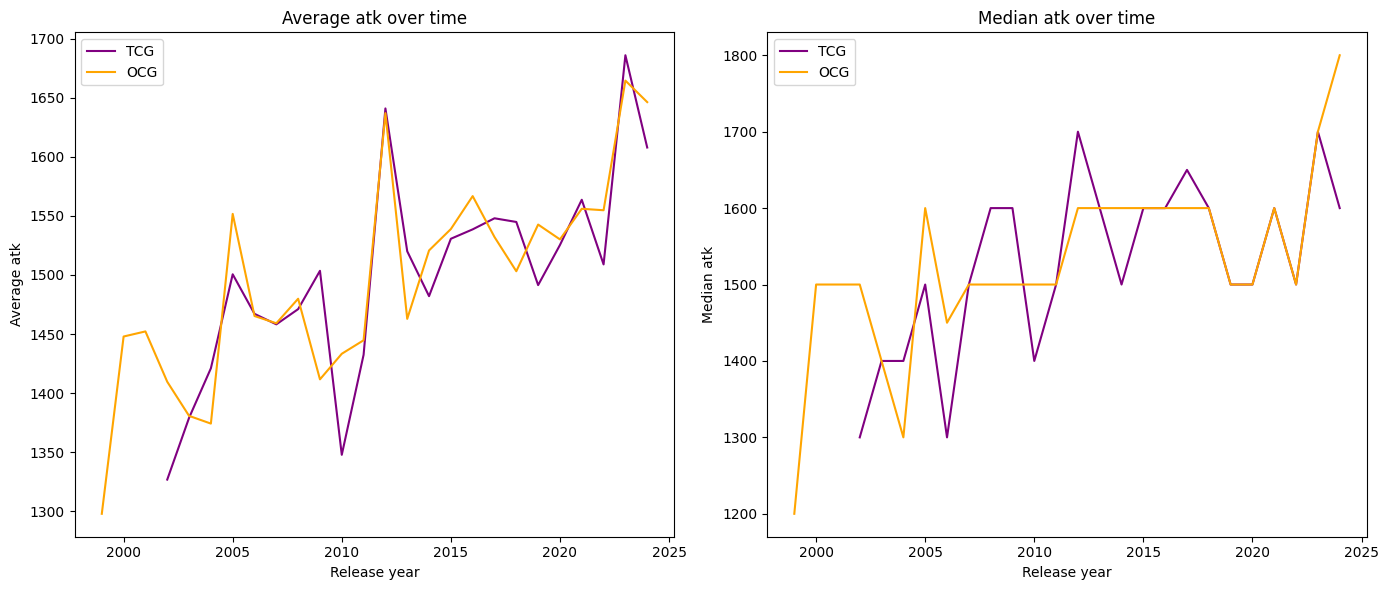

In [25]:
# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

m_card_quantitative_values_plot("Average", avg_atk_tcg, avg_atk_ocg, "atk", "tcg_year", "ocg_year", ax=axes[0])

m_card_quantitative_values_plot("Median", median_atk_tcg, median_atk_ocg, "atk", "tcg_year", "ocg_year", ax=axes[1])

plt.tight_layout()
plt.show()

What was squeuing the data for tcg in 2001 is the promotional card Summoned Skull which has 2500 atk points. I will change its date to when it was officially released in 2002.

###  Defense points

In [26]:
# Group by the year and month and calculate the mean and median defense 
avg_def_tcg = cards_data[cards_data["primary_type"]=="Monster Card"].groupby("tcg_year")["def"].mean().reset_index()
avg_def_ocg = cards_data[cards_data["primary_type"]=="Monster Card"].groupby("ocg_year")["def"].mean().reset_index()

median_def_tcg = cards_data[cards_data["primary_type"]=="Monster Card"].groupby("tcg_year")["def"].median().reset_index()
median_def_ocg = cards_data[cards_data["primary_type"]=="Monster Card"].groupby("ocg_year")["def"].median().reset_index()

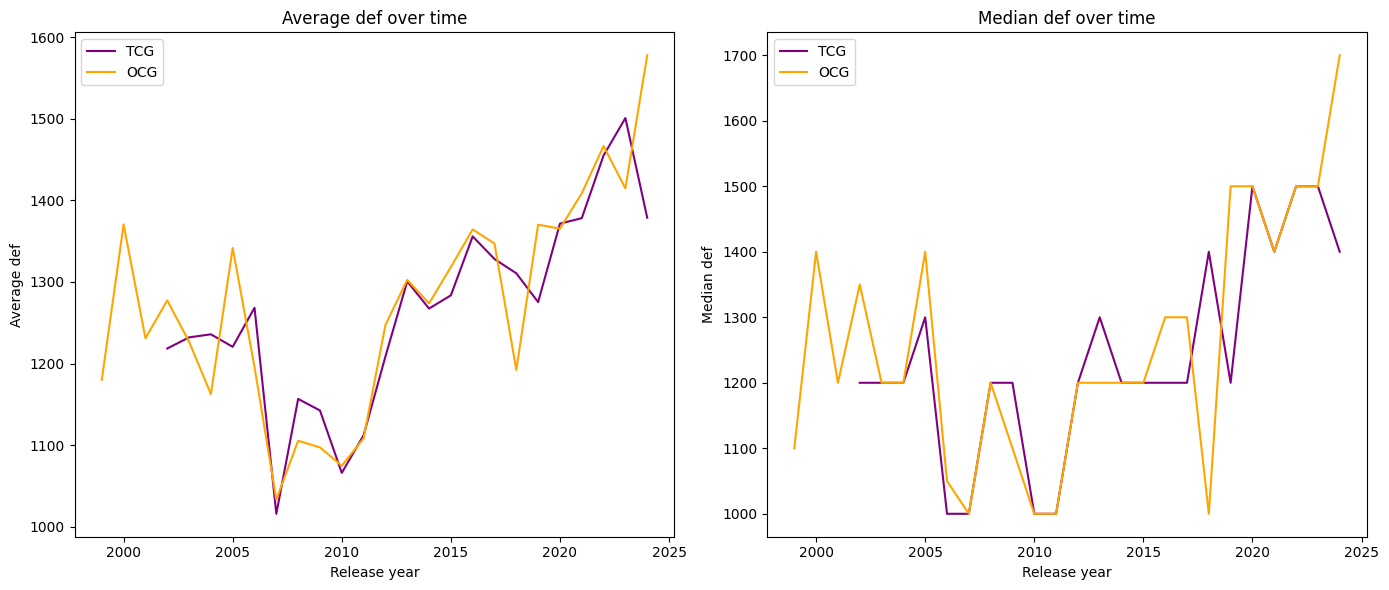

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

m_card_quantitative_values_plot("Average", avg_def_tcg, avg_def_ocg, "def", "tcg_year", "ocg_year", ax=axes[0])

m_card_quantitative_values_plot("Median", median_def_tcg, median_def_ocg, "def", "tcg_year", "ocg_year", ax=axes[1])

plt.tight_layout()
plt.show()

### Levels

In [28]:
# Group by the year and month and calculate the mean and median level 
avg_level_tcg = cards_data[cards_data["primary_type"]=="Monster Card"].groupby("tcg_year")["level"].mean().reset_index()
avg_level_ocg = cards_data[cards_data["primary_type"]=="Monster Card"].groupby("ocg_year")["level"].mean().reset_index()

median_level_tcg = cards_data[cards_data["primary_type"]=="Monster Card"].groupby("tcg_year")["level"].median().reset_index()
median_level_ocg = cards_data[cards_data["primary_type"]=="Monster Card"].groupby("ocg_year")["level"].median().reset_index()

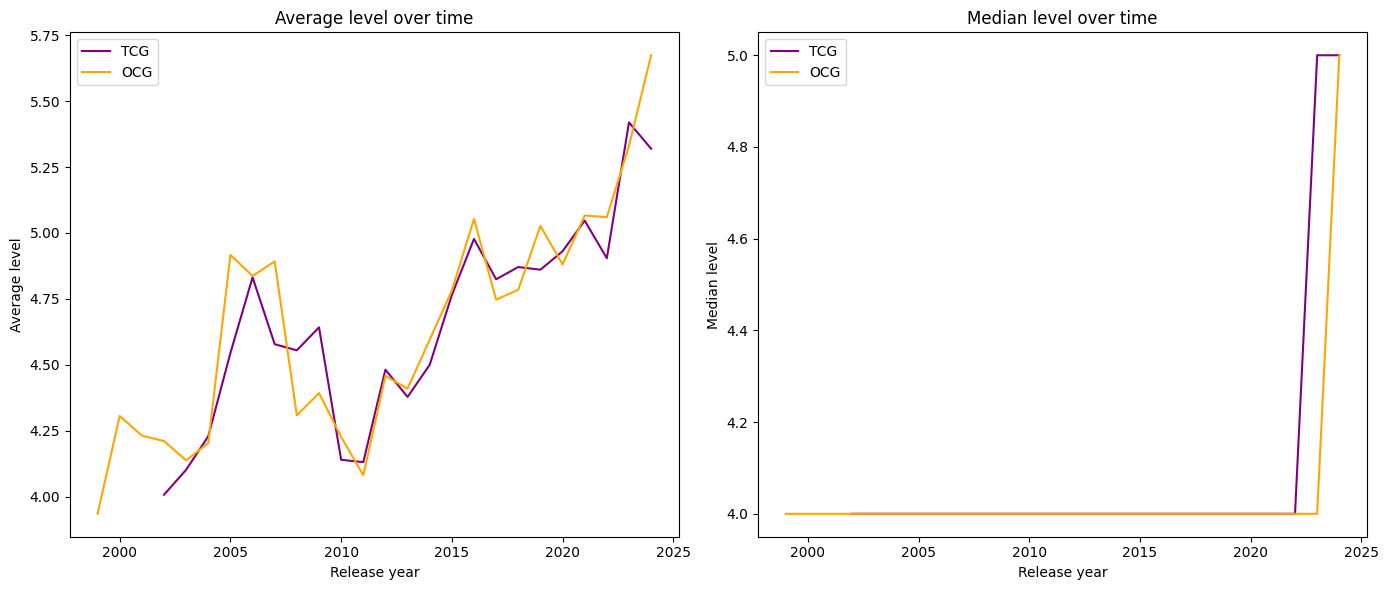

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

m_card_quantitative_values_plot("Average", avg_level_tcg, avg_level_ocg, "level", "tcg_year", "ocg_year", ax=axes[0])

m_card_quantitative_values_plot("Median", median_level_tcg, median_level_ocg, "level", "tcg_year", "ocg_year", ax=axes[1])

plt.tight_layout()
plt.show()

The number of cards released with higher levels could partially explain the need to special summon Monsters for example with chains. 

### Attributes

In [30]:
#making a function to use in 2 different graphs
def m_card_stacked_hist_over_time(time_col= None, parameter_col = None , formats=None, ax=None):
    data_attributes = (cards_data[cards_data["primary_type"] == "Monster Card"].groupby([time_col, parameter_col]).size().reset_index(name="count"))

    # If no ax is provided, create a new figure
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    sns.histplot(data=data_attributes, y=time_col, hue=parameter_col, weights="count", multiple="stack", palette='hsv', legend=True, bins=range(cards_data[time_col].min(), cards_data[time_col].max() + 1), ax=ax)
    
    # Add labels and title
    ax.set_title(f"Distribution of {parameter_col} over time {formats}", fontsize=14)
    ax.set_ylabel("Release Year", fontsize=12)
    ax.set_xlabel("Number of Monster cards", fontsize=12)
    ax.tick_params(axis="x", rotation=45) 
    
    if ax is None:
        plt.show()    

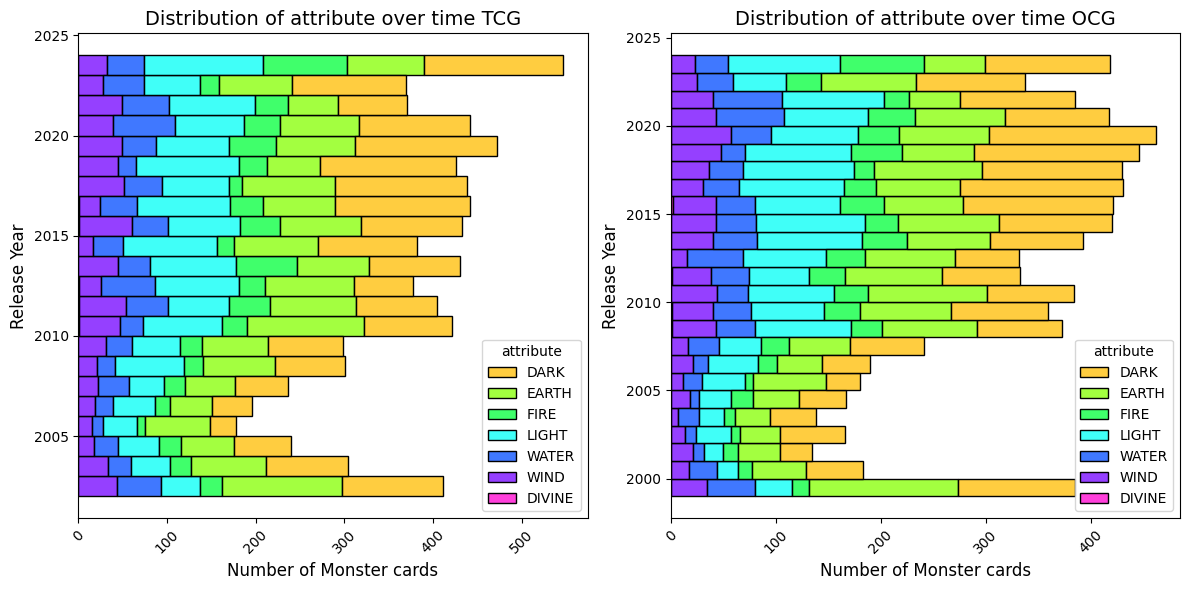

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

m_card_stacked_hist_over_time(time_col= "tcg_year", parameter_col = "attribute", formats= "TCG", ax=axes[0])
m_card_stacked_hist_over_time(time_col= "ocg_year", parameter_col = "attribute", formats= "OCG", ax=axes[1])

plt.tight_layout()
plt.show()

In [32]:
#Finding out when the divine cards where released and how many there are in the whole data set

print(cards_data.loc[cards_data["attribute"] == "DIVINE", "name"])
print("\n So there are only",len(cards_data.loc[cards_data["attribute"] == "DIVINE"]), "cards with the DIVINE attribute, in the whole dataset.")

8249                          Obelisk the Tormentor
10461                         Slifer the Sky Dragon
11696                       The Winged Dragon of Ra
11697    The Winged Dragon of Ra - Immortal Phoenix
11698         The Winged Dragon of Ra - Sphere Mode
Name: name, dtype: object

 So there are only 5 cards with the DIVINE attribute, in the whole dataset.


### Races

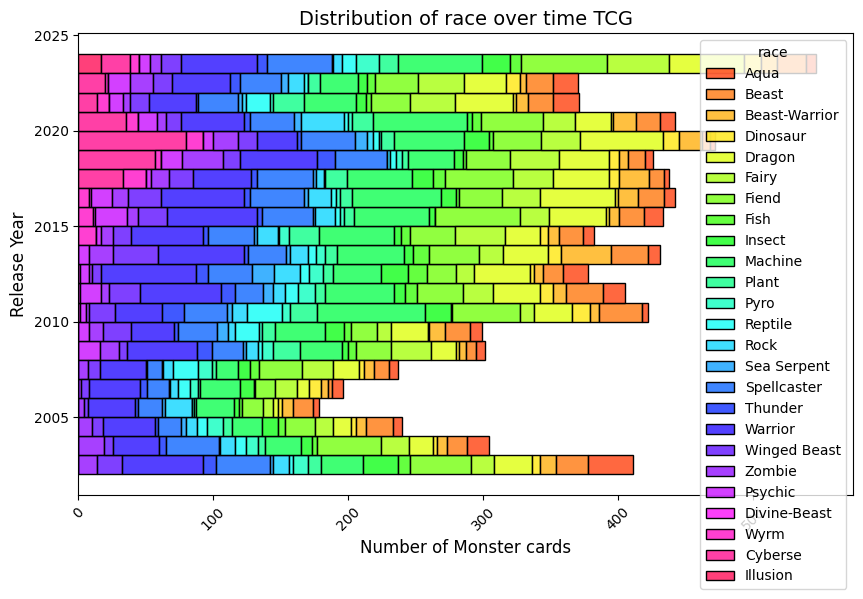

In [33]:
m_card_stacked_hist_over_time(time_col= "tcg_year", parameter_col = "race", formats= "TCG")

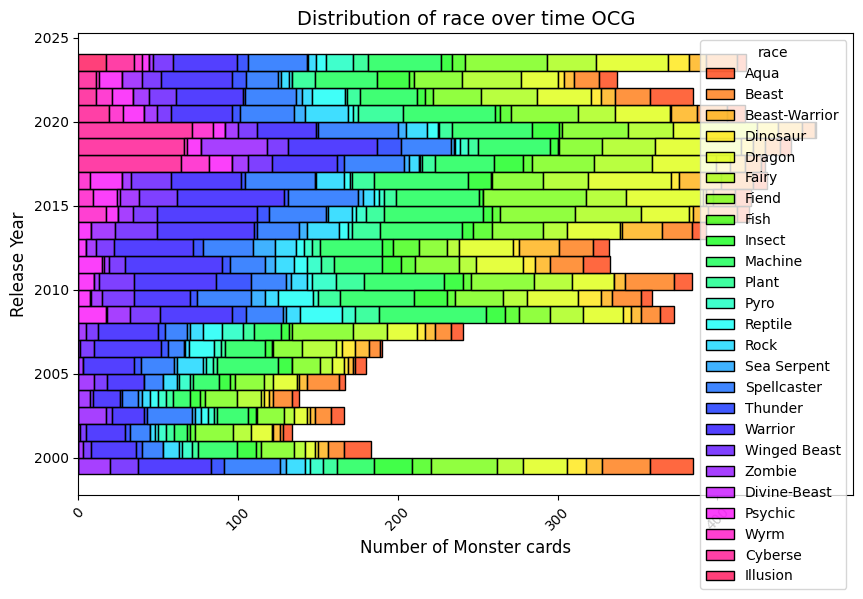

In [34]:
m_card_stacked_hist_over_time(time_col= "ocg_year", parameter_col = "race", formats= "OCG")

In [35]:
cards_data["race"].nunique()

33

In [36]:
print("If you think there are a lot of different races of monsters, wait until you see the number of archetypes.\nBut it makes sense since an archetype is a group of card that have a similar name or style. There are",
      cards_data["archetype"].nunique(), "archetypes." )

If you think there are a lot of different races of monsters, wait until you see the number of archetypes.
But it makes sense since an archetype is a group of card that have a similar name or style. There are 533 archetypes.


### The complexification of the game through the descriptions of the cards - the way chains dominate

In [37]:
#format the descriptions
cards_data["number_char_in_desc"]=cards_data["desc"].astype(str).apply(len)

cards_data["reformated_desc"]=cards_data["desc"].str.lower()

cards_data["number_char_in_desc"].head()

0     96
1    188
2    356
3    145
4    477
Name: number_char_in_desc, dtype: int64

In [38]:
cards_data["desc"].str.count('.').head()

0     96
1    188
2    356
3    145
4    477
Name: desc, dtype: int64

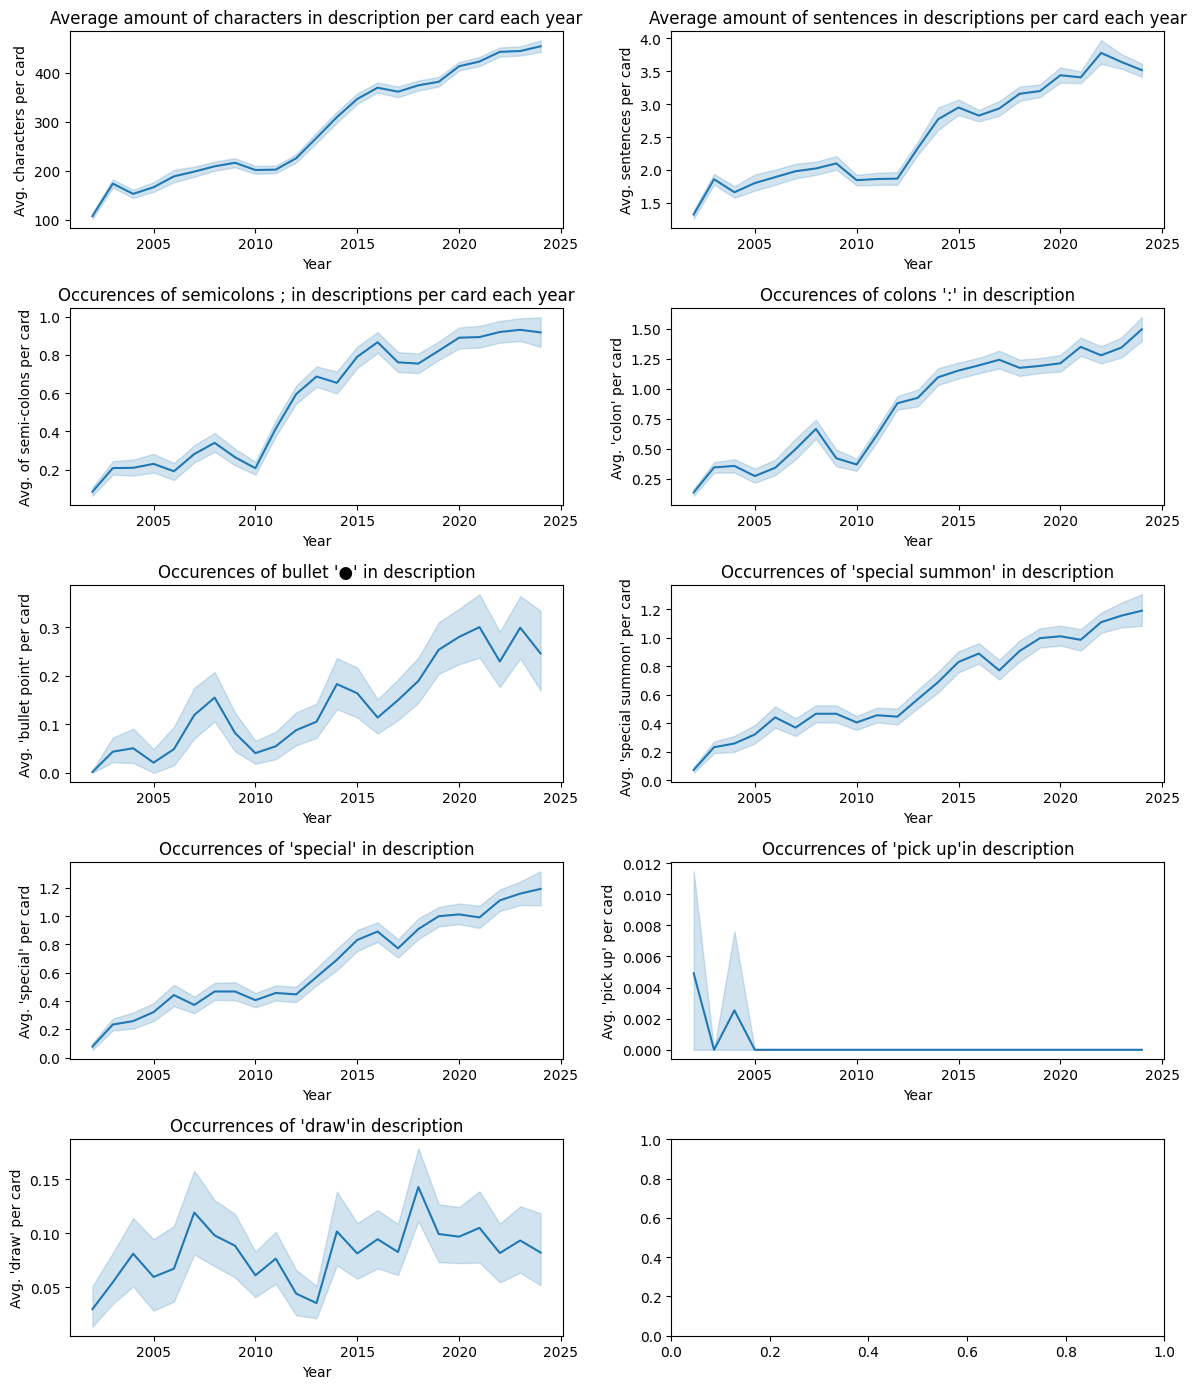

In [39]:
#making the grid
fig, axes = plt.subplots(5, 2, figsize=(12, 14))

sns.lineplot(cards_data, x="tcg_year", y="number_char_in_desc", ax=axes[0,0])
axes[0, 0].set_title("Average amount of characters in description per card each year")
axes[0, 0].set_xlabel("Year")
axes[0, 0].set_ylabel("Avg. characters per card")

sns.lineplot(cards_data, x="tcg_year", y=cards_data["desc"].str.count(r'\.'), ax=axes[0,1])
axes[0,1].set_title("Average amount of sentences in descriptions per card each year")
axes[0,1].set_xlabel("Year")
axes[0,1].set_ylabel("Avg. sentences per card")

sns.lineplot(cards_data, x="tcg_year", y=cards_data["desc"].str.count(';'), ax=axes[1,0])
axes[1,0].set_title("Occurences of semicolons ; in descriptions per card each year")
axes[1,0].set_xlabel("Year")
axes[1,0].set_ylabel("Avg. of semi-colons per card")

sns.lineplot(cards_data, x="tcg_year", y=cards_data["desc"].str.count(':'), ax=axes[1,1])
axes[1,1].set_title("Occurences of colons ':' in description")
axes[1,1].set_xlabel("Year")
axes[1,1].set_ylabel("Avg. 'colon' per card")

sns.lineplot(cards_data, x="tcg_year", y=cards_data["desc"].str.count('●'), ax=axes[2,0])
axes[2,0].set_title("Occurences of bullet '●' in description")
axes[2,0].set_xlabel("Year")
axes[2,0].set_ylabel("Avg. 'bullet point' per card")

sns.lineplot(cards_data, x="tcg_year", y=cards_data["reformated_desc"].str.count('special summon'), ax=axes[2,1])
axes[2,1].set_title("Occurrences of 'special summon' in description")
axes[2,1].set_xlabel("Year")
axes[2,1].set_ylabel("Avg. 'special summon' per card ")

sns.lineplot(cards_data, x="tcg_year", y=cards_data["reformated_desc"].str.count('special'), ax=axes[3,0])
axes[3,0].set_title("Occurrences of 'special' in description")
axes[3,0].set_xlabel("Year")
axes[3,0].set_ylabel("Avg. 'special' per card")

sns.lineplot(cards_data, x="tcg_year", y=cards_data["reformated_desc"].str.count('pick up'), ax=axes[3,1])
axes[3,1].set_title("Occurrences of 'pick up'in description")
axes[3,1].set_xlabel("Year")
axes[3,1].set_ylabel("Avg. 'pick up' per card")

sns.lineplot(cards_data, x="tcg_year", y=cards_data["reformated_desc"].str.count('draw'), ax=axes[4,0])
axes[4,0].set_title("Occurrences of 'draw'in description")
axes[4,0].set_xlabel("Year")
axes[4,0].set_ylabel("Avg. 'draw' per card")

plt.tight_layout()
plt.show()

We are going to analyse the cards historically :
- How many cards are authorized at a given time ? /ban lists
    - difference TNG and OCG
- What are the trends in type of monsters ?
        - race 
        - attribute
        - levels 
        - def
        - atk
        - has effect ?
- More information on the banned cards

And we are going to investigate the special effect chains which are supposed to have changed the game from its origins:
- Is the the use of semicolons correlated to the lengths of the description of the card ?
- Is the the use of semicolons correlated to the possible effect of the card ?
- Chain keywords in the game + has effect
- Bulletpoint use

According to Wikipedia, this is the definition of Chains in the Yu-Gi-Oh game :

A chain is a stack of card effects activated one after the other. It exists for the management of multiple card effects.

A chain is created when the effects of more than one card are activated at the same time, or when a player activates an effect after a card is played, but before the card impacts the game.

If the effect of a card is activated, the opponent always has the possibility to reply with an effect of their own cards, thus creating a chain.

If your opponent replied with an effect, you can choose to reply back and add another effect to the chain. If your opponent chooses not to reply, you can add a second effect and create a chain off of the activation of your own card. Each player can then continue to add effects to the chain. The chain ends when the players wish to not play any more cards. Should this happen, the chain is resolved: the resolution is performed in reverse order of play, starting with the effect of the most recently played card.

It is advised to not resolve card effects before ensuring that a chain had not been created.